In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.09000000171363354
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from MADDPG_agent import MADDPG
import torch
from collections import deque
from matplotlib import pyplot as plt

/home/shreyans/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
agent = MADDPG(seed=2, noise_start=0.5, update_every=2, gamma=1, t_stop_noise=30000)
n_episodes = 6000
max_t = 1000
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []

for i_episode in range(1, n_episodes+1):
    rewards = []
    env_info = env.reset()[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    # loop over steps
    for t in range(max_t):
        # select an action
        action = agent.act(state)
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        rewards_vec = env_info.rewards
        done = env_info.local_done
        # update and train agent with returned information
        agent.step(state, action, rewards_vec, next_state, done)
        state = next_state
        rewards.append(rewards_vec)
        if any(done):
            break

    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")
    
    # log average score every 200 episodes
    if i_episode % 200 == 0:
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))
        agent.save_agents()

    # break and report success if environment is solved
    if np.mean(scores_deque)>=.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        agent.save_agents()
        break

/home/shreyans/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 200	Average Score: 0.048
Episode 400	Average Score: 0.034
Episode 600	Average Score: 0.033
Episode 800	Average Score: 0.071
Episode 1000	Average Score: 0.069
Episode 1200	Average Score: 0.151
Episode 1400	Average Score: 0.199
Episode 1600	Average Score: 0.242
Episode 1800	Average Score: 0.135
Episode 2000	Average Score: 0.061
Episode 2200	Average Score: 0.147
Episode 2400	Average Score: 0.175
Episode 2600	Average Score: 0.288
Episode 2800	Average Score: 0.288
Episode 3000	Average Score: 0.179
Episode 3200	Average Score: 0.381
Episode 3316	Average Score: 0.508
Environment solved in 3316 episodes!	Average Score: 0.508


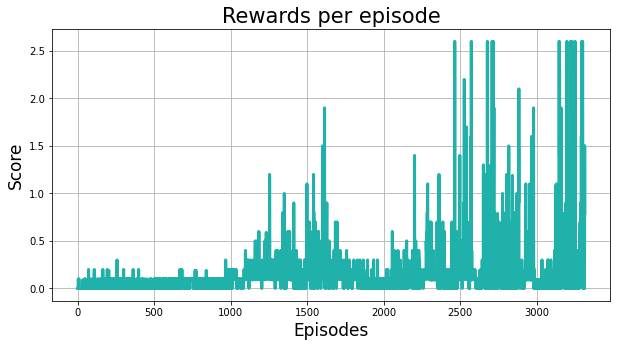

In [9]:
plt.figure(figsize=(10,5))
plt.plot(scores, color='lightseagreen', linewidth=3)
plt.xlabel('Episodes', fontsize=17)
plt.ylabel('Score', fontsize=17)
plt.title(f'Rewards per episode', fontsize=21)
plt.grid()
plt.show()

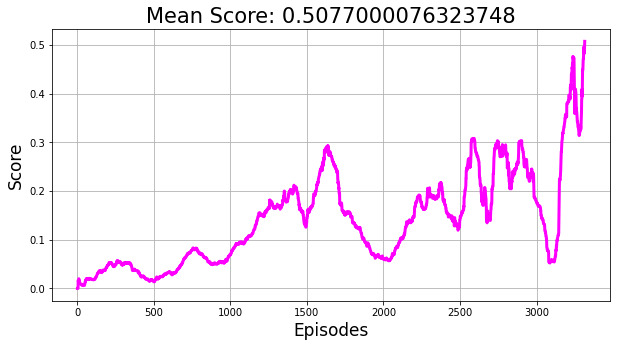

In [10]:
plt.figure(figsize=(10,5))
plt.plot(scores_avg, color='fuchsia', linewidth=3)
plt.xlabel('Episodes', fontsize=17)
plt.ylabel('Score', fontsize=17)
plt.title(f'Mean Score: {scores_avg[-1]}', fontsize=21)
plt.grid()
plt.show()

In [11]:
env.close()